### Random Forest Classification

In [5]:
library(raster)
library(randomForest)
library(rgdal)
library(rgeos)
set.seed(1)
setwd("~/RDemo/capstone/Sentinel2data")

In [6]:
img <- brick("masked.tif")
names(img)
names(img) <- c("b1", "b2", "b3", "b4", "b5", "b6", "b7") # change the name of the bands
names(img)

[1] "masked.1" "masked.2" "masked.3" "masked.4" "masked.5" "masked.6" "masked.7"

[1] "b1" "b2" "b3" "b4" "b5" "b6" "b7"

In [7]:
load(file="smp.rda")
head(smp)

b1,b2,b3,b4,b5,b6,b7,cl
1201,719,926,1212,1615,1445,1664,ind
1201,1222,1382,1334,1615,1445,1664,ind
1201,1282,1382,1724,1705,1923,1822,ind
1201,1496,1660,1818,1705,1923,1822,ind
935,680,767,784,1051,1047,978,ind
935,766,748,901,1051,1047,978,ind


In [8]:
colSums(is.na(smp)) # verify if there are NA values

b1 b2 b3 b4 b5 b6 b7 cl 
 0  0  0  0  0  0  0  0

In [9]:
table(smp$cl) # identify the number of available training samples per class


   b    c    f    g  ind   rh   rl    w 
1200 2673  352  435  948  513  460  309 

We can see that we currently have an imbalanced data set (one class contains significantly more samples than the other). This often leads to the problem that classifiers favor and overclass those strongly-represented classes in the classification. 
In this case, we will perform an undersampling procedure (down-sizing the non-events by removing observations at random until the dataset is balanced):

In [10]:
smp.size <- rep(min(summary(smp$cl)), nlevels(smp$cl)) # down-sampling
smp.size

[1] 309 309 309 309 309 309 309 309

The complete training takes place via just one function call of tuneRF(); this fc searches for the best param setting for mtry - the number of variables available for each tree node. The number of trees to grow 250-1000 trees are usually sufficient, the more the better, but many trees will increase calculation time. We need to specify training samples as x (i.e. all columns of our smp dataframe except the last one) and the corresponding class labels as y (the last column of smp dataframe called cl):

mtry = 2  OOB error = 3.93% 
Searching left ...
mtry = 1 	OOB error = 4.37% 
-0.1107011 0.05 
Searching right ...
mtry = 4 	OOB error = 3.54% 
0.099631 0.05 
mtry = 7 	OOB error = 3.28% 
0.07377049 0.05 


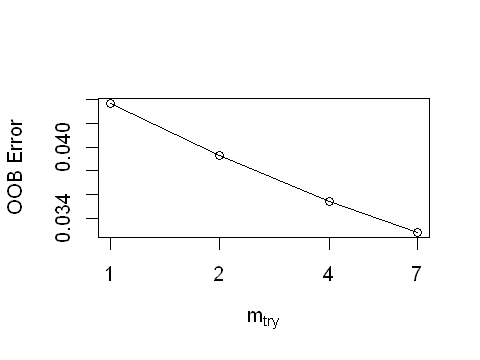

In [11]:
options(repr.plot.width=4, repr.plot.height=3)
RF_model <- tuneRF(x = smp[-ncol(smp)], # specify training samples
                   y = smp$cl,           # specify the class label
                   sampsize = smp.size,  # define how many samples it should draw per class
                   strata = smp$cl,      # defines the column which should use for this stratified sampling
                   ntree = 300,          # trees to grow
                   importance = TRUE,    # allows the subsequent assessment of the variable importance
                   doBest = TRUE         # get the RF with the optimal mtry
)

Using tuneRF we automatically get the above plot about the OOB errors depending on different mtry settings the optimal mtry (the number of variables randomly sampled as candidates at each split) - here is 7

In [12]:
RF_model # get the confusion matrix based on the training data


Call:
 randomForest(x = x, y = y, mtry = res[which.min(res[, 2]), 1],      strata = ..2, sampsize = ..1, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 3.28%
Confusion matrix:
       b    c   f   g ind  rh  rl   w class.error
b   1154    0   2   0  22  15   7   0 0.038333333
c      0 2657   0   0   0   5  11   0 0.005985784
f      0    0 348   0   0   0   4   0 0.011363636
g      0    0   3 429   0   0   3   0 0.013793103
ind   36   13   1   0 849  39  10   0 0.104430380
rh     4    4   0   0  13 476  15   1 0.072124756
rl     3    4   2   1   3   4 443   0 0.036956522
w      0    0   1   0   0   0   0 308 0.003236246

The Out-of-Bag Error (Misclassification Rate) is 3.28%

Plot the **variable importance** to identify which are the most important features to use in the classification model (here we have band 1, band 7, band 4 and band 5 showing more importance):

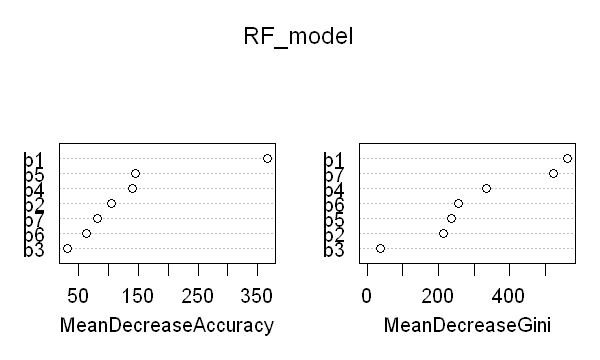

In [13]:
options(repr.plot.width=5, repr.plot.height=4)
varImpPlot(RF_model)

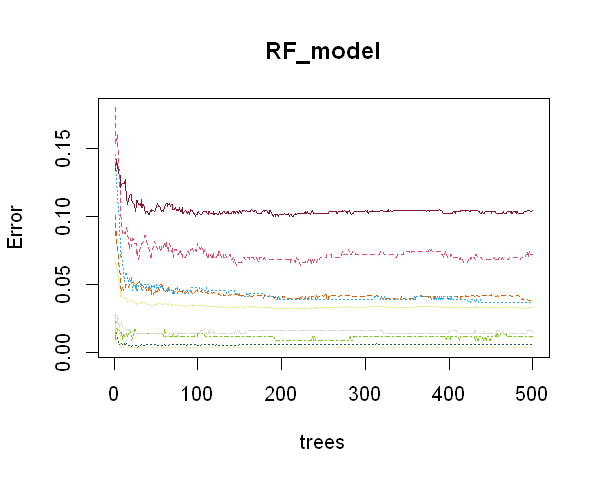

In [14]:
options(repr.plot.width=5, repr.plot.height=4)
plot(RF_model, col = c("#e9eba4","#D95F02","#14614a","#78c91c","#e0d7d1","#801630","#de4e71","#2eabf0"))
# We can see a decrease in the error with increasing number of trees, where the urban classes have the highest OOB error values

#### Manual tuning of RF model

In [15]:
oob_error <- double(7) # similar to rep(); create double precision vectors
test_error <- double(7)


Bring image data into a data frame:

In [16]:
img2 <- stack(img)
imgdf <- as.data.frame(img2)
head(imgdf)

b1,b2,b3,b4,b5,b6,b7
NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA


In [17]:
imgdf <- na.omit(imgdf)
head(imgdf)
dim(imgdf)

,b1,b2,b3,b4,b5,b6,b7
1884,254,292,451,400,787,1697,2036
1885,254,282,483,400,787,1697,2036
1886,254,275,436,347,893,1848,2163
5453,257,292,426,355,709,1597,1884
5454,254,295,502,392,787,1697,2036
5455,254,292,480,349,787,1697,2036


[1] 9359554       7

In [18]:
for (mtry in 1:7){
  fit_RF <- randomForest(smp$cl ~., smp[-ncol(smp)], ntree=300, mtry=mtry)
  oob_error[mtry] <- fit_RF$err.rate[300] # error of all trees fitted
  pred <- predict(fit_RF, imgdf)
  test_error[mtry] <- with(imgdf, mean(smp$cl == pred))
  cat(mtry, " ") # printing the output to the console
}

Warning message in `==.default`(smp$cl, pred):
"longer object length is not a multiple of shorter object length"Warning message in is.na(e1) | is.na(e2):
"longer object length is not a multiple of shorter object length"

1  

Warning message in `==.default`(smp$cl, pred):
"longer object length is not a multiple of shorter object length"Warning message in is.na(e1) | is.na(e2):
"longer object length is not a multiple of shorter object length"

2  

Warning message in `==.default`(smp$cl, pred):
"longer object length is not a multiple of shorter object length"Warning message in is.na(e1) | is.na(e2):
"longer object length is not a multiple of shorter object length"

3  

Warning message in `==.default`(smp$cl, pred):
"longer object length is not a multiple of shorter object length"Warning message in is.na(e1) | is.na(e2):
"longer object length is not a multiple of shorter object length"

4  

Warning message in `==.default`(smp$cl, pred):
"longer object length is not a multiple of shorter object length"Warning message in is.na(e1) | is.na(e2):
"longer object length is not a multiple of shorter object length"

5  

Warning message in `==.default`(smp$cl, pred):
"longer object length is not a multiple of shorter object length"Warning message in is.na(e1) | is.na(e2):
"longer object length is not a multiple of shorter object length"

6  

Warning message in `==.default`(smp$cl, pred):
"longer object length is not a multiple of shorter object length"Warning message in is.na(e1) | is.na(e2):
"longer object length is not a multiple of shorter object length"

7  

In [19]:
mean(fit_RF$err.rate)

[1] 0.03423659

In [20]:
test_error

[1] 0.1154466 0.1159627 0.1161130 0.1165716 0.1174117 0.1179989 0.1192287

In [21]:
oob_error

[1] 0.03178520 0.02815675 0.02481858 0.02336720 0.02394775 0.02438316 0.02612482

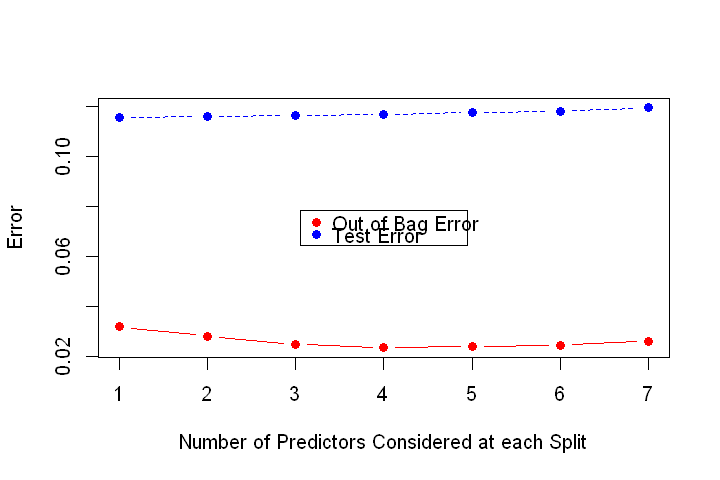

In [23]:
library(plotly); library(ggplot2)
options(repr.plot.width=6, repr.plot.height=5)
matplot(1:mtry, cbind(oob_error, test_error), pch=19, col=c("red","blue"), type="b",
        ylab="Error", xlab="Number of Predictors Considered at each Split")
legend("center", legend = c("Out of Bag Error", "Test Error"), pch=19, col=c("red","blue"))

In [24]:
fit_RF


Call:
 randomForest(formula = smp$cl ~ ., data = smp[-ncol(smp)], ntree = 300,      mtry = mtry) 
               Type of random forest: classification
                     Number of trees: 300
No. of variables tried at each split: 7

        OOB estimate of  error rate: 2.61%
Confusion matrix:
       b    c   f   g ind  rh  rl   w class.error
b   1171    0   1   0  19   6   3   0 0.024166667
c      0 2669   0   0   2   0   2   0 0.001496446
f      0    0 350   0   0   0   2   0 0.005681818
g      0    0   3 429   0   0   3   0 0.013793103
ind   23    6   1   0 889  21   8   0 0.062236287
rh     9    3   1   0  26 462  12   0 0.099415205
rl     6    4   2   2   9   5 432   0 0.060869565
w      0    0   1   0   0   0   0 308 0.003236246

In [25]:
fit_RF <- randomForest(smp$cl ~., smp[-ncol(smp)], ntree=200, mtry=4)
fit_RF


Call:
 randomForest(formula = smp$cl ~ ., data = smp[-ncol(smp)], ntree = 200,      mtry = 4) 
               Type of random forest: classification
                     Number of trees: 200
No. of variables tried at each split: 4

        OOB estimate of  error rate: 2.45%
Confusion matrix:
       b    c   f   g ind  rh  rl   w class.error
b   1177    0   1   0  13   8   1   0 0.019166667
c      0 2669   0   0   1   0   3   0 0.001496446
f      0    0 350   0   0   0   2   0 0.005681818
g      0    0   2 430   0   0   3   0 0.011494253
ind   32    5   1   0 885  17   8   0 0.066455696
rh    13    1   0   0  21 466  11   1 0.091617934
rl     4    4   1   2   8   5 436   0 0.052173913
w      0    0   1   0   0   0   0 308 0.003236246

In [26]:
save(fit_RF, file = "RF_model.RData")
# load("RF_model.RData")

Predict image data with our so far best performing Random Forest model:

In [27]:
# result <- predict(img,  fit_RF, filename = "RF_classification2.tif", overwrite = TRUE)

Plot the resulted classification map

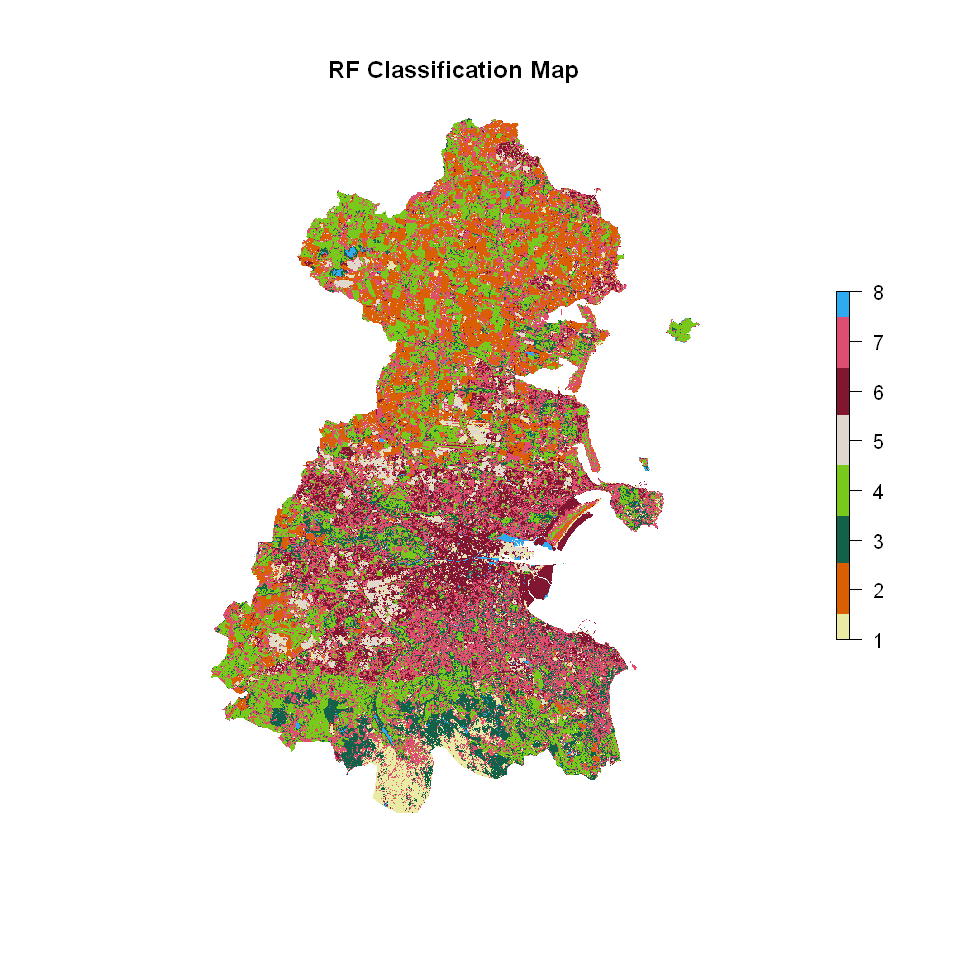

In [31]:
plot(result, 
     main = "RF Classification Map",
     axes = FALSE, 
     box = FALSE,
     col = c("#e9eba4", # bareland
             "#D95F02", # cropland
             "#14614a", # forest
             "#78c91c", # green_area
             "#e0d7d1", # industrial
             "#801630", # residential_high
             "#de4e71", # residential_low
             "#2eabf0"  # water
     )
)